In [3]:
import torch.nn.functional as F

In [4]:
import torch
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = args.lr * (0.1 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

def get_loss_weight(loss_weight):
    piece = 1/(2 * loss_weight + 1)
    return (torch.from_numpy(piece * np.array([1,loss_weight]))).float()

In [5]:
import torch.nn as nn
import torch

class Modified3DUNet(nn.Module):
    def __init__(self, in_channels, n_classes, base_n_filter = 8):
        super(Modified3DUNet, self).__init__()
        self.in_channels = in_channels
        self.n_classes = n_classes
        self.base_n_filter = base_n_filter

        self.lrelu = nn.LeakyReLU()
        self.dropout3d = nn.Dropout3d(p=0.6)
        self.upsacle = nn.Upsample(scale_factor=2, mode='nearest')
        self.softmax = nn.Softmax(dim=1)

        # Level 1 context pathway
        self.conv3d_c1_1 = nn.Conv3d(self.in_channels, self.base_n_filter, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv3d_c1_2 = nn.Conv3d(self.base_n_filter, self.base_n_filter, kernel_size=3, stride=1, padding=1, bias=False)
        self.lrelu_conv_c1 = self.lrelu_conv(self.base_n_filter, self.base_n_filter)
        self.inorm3d_c1 = nn.InstanceNorm3d(self.base_n_filter)

        # Level 2 context pathway
        self.conv3d_c2 = nn.Conv3d(self.base_n_filter, self.base_n_filter*2, kernel_size=3, stride=2, padding=1, bias=False)
        self.norm_lrelu_conv_c2 = self.norm_lrelu_conv(self.base_n_filter*2, self.base_n_filter*2)
        self.inorm3d_c2 = nn.InstanceNorm3d(self.base_n_filter*2)

        # Level 3 context pathway
        self.conv3d_c3 = nn.Conv3d(self.base_n_filter*2, self.base_n_filter*4, kernel_size=3, stride=2, padding=1, bias=False)
        self.norm_lrelu_conv_c3 = self.norm_lrelu_conv(self.base_n_filter*4, self.base_n_filter*4)
        self.inorm3d_c3 = nn.InstanceNorm3d(self.base_n_filter*4)

        # Level 4 context pathway
        self.conv3d_c4 = nn.Conv3d(self.base_n_filter*4, self.base_n_filter*8, kernel_size=3, stride=2, padding=1, bias=False)
        self.norm_lrelu_conv_c4 = self.norm_lrelu_conv(self.base_n_filter*8, self.base_n_filter*8)
        self.inorm3d_c4 = nn.InstanceNorm3d(self.base_n_filter*8)

        # Level 5 context pathway, level 0 localization pathway
        self.conv3d_c5 = nn.Conv3d(self.base_n_filter*8, self.base_n_filter*16, kernel_size=3, stride=2, padding=1, bias=False)
        self.norm_lrelu_conv_c5 = self.norm_lrelu_conv(self.base_n_filter*16, self.base_n_filter*16)
        self.norm_lrelu_upscale_conv_norm_lrelu_l0 = self.norm_lrelu_upscale_conv_norm_lrelu(self.base_n_filter*16, self.base_n_filter*8)

        self.conv3d_l0 = nn.Conv3d(self.base_n_filter*8, self.base_n_filter*8, kernel_size = 1, stride=1, padding=0, bias=False)
        self.inorm3d_l0 = nn.InstanceNorm3d(self.base_n_filter*8)

        # Level 1 localization pathway
        self.conv_norm_lrelu_l1 = self.conv_norm_lrelu(self.base_n_filter*16, self.base_n_filter*16)
        self.conv3d_l1 = nn.Conv3d(self.base_n_filter*16, self.base_n_filter*8, kernel_size=1, stride=1, padding=0, bias=False)
        self.norm_lrelu_upscale_conv_norm_lrelu_l1 = self.norm_lrelu_upscale_conv_norm_lrelu(self.base_n_filter*8, self.base_n_filter*4)

        # Level 2 localization pathway
        self.conv_norm_lrelu_l2 = self.conv_norm_lrelu(self.base_n_filter*8, self.base_n_filter*8)
        self.conv3d_l2 = nn.Conv3d(self.base_n_filter*8, self.base_n_filter*4, kernel_size=1, stride=1, padding=0, bias=False)
        self.norm_lrelu_upscale_conv_norm_lrelu_l2 = self.norm_lrelu_upscale_conv_norm_lrelu(self.base_n_filter*4, self.base_n_filter*2)

        # Level 3 localization pathway
        self.conv_norm_lrelu_l3 = self.conv_norm_lrelu(self.base_n_filter*4, self.base_n_filter*4)
        self.conv3d_l3 = nn.Conv3d(self.base_n_filter*4, self.base_n_filter*2, kernel_size=1, stride=1, padding=0, bias=False)
        self.norm_lrelu_upscale_conv_norm_lrelu_l3 = self.norm_lrelu_upscale_conv_norm_lrelu(self.base_n_filter*2, self.base_n_filter)

        # Level 4 localization pathway
        self.conv_norm_lrelu_l4 = self.conv_norm_lrelu(self.base_n_filter*2, self.base_n_filter*2)
        self.conv3d_l4 = nn.Conv3d(self.base_n_filter*2, self.n_classes, kernel_size=1, stride=1, padding=0, bias=False)

        self.ds2_1x1_conv3d = nn.Conv3d(self.base_n_filter*8, self.n_classes, kernel_size=1, stride=1, padding=0, bias=False)
        self.ds3_1x1_conv3d = nn.Conv3d(self.base_n_filter*4, self.n_classes, kernel_size=1, stride=1, padding=0, bias=False)




    def conv_norm_lrelu(self, feat_in, feat_out):
        return nn.Sequential(
            nn.Conv3d(feat_in, feat_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm3d(feat_out),
            nn.LeakyReLU())

    def norm_lrelu_conv(self, feat_in, feat_out):
        return nn.Sequential(
            nn.InstanceNorm3d(feat_in),
            nn.LeakyReLU(),
            nn.Conv3d(feat_in, feat_out, kernel_size=3, stride=1, padding=1, bias=False))

    def lrelu_conv(self, feat_in, feat_out):
        return nn.Sequential(
            nn.LeakyReLU(),
            nn.Conv3d(feat_in, feat_out, kernel_size=3, stride=1, padding=1, bias=False))

    def norm_lrelu_upscale_conv_norm_lrelu(self, feat_in, feat_out):
        return nn.Sequential(
            nn.InstanceNorm3d(feat_in),
            nn.LeakyReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            # should be feat_in*2 or feat_in
            nn.Conv3d(feat_in, feat_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm3d(feat_out),
            nn.LeakyReLU())

    def forward(self, x):
        #  Level 1 context pathway
        out = self.conv3d_c1_1(x)
#         print(out.size())
        residual_1 = out
        out = self.lrelu(out)
        out = self.conv3d_c1_2(out)
        out = self.dropout3d(out)
        out = self.lrelu_conv_c1(out)
        # Element Wise Summation
#         print(out.size())
        out += residual_1
        context_1 = self.lrelu(out)
        out = self.inorm3d_c1(out)
        out = self.lrelu(out)

        # Level 2 context pathway
        out = self.conv3d_c2(out)
#         print(out.size())
        residual_2 = out
        out = self.norm_lrelu_conv_c2(out)
        out = self.dropout3d(out)
        out = self.norm_lrelu_conv_c2(out)
#         print(out.size())
        out += residual_2
        out = self.inorm3d_c2(out)
        out = self.lrelu(out)
        context_2 = out

        # Level 3 context pathway
        out = self.conv3d_c3(out)
#         print(out.size())
        residual_3 = out
        out = self.norm_lrelu_conv_c3(out)
        out = self.dropout3d(out)
        out = self.norm_lrelu_conv_c3(out)
#         print(out.size())
        out += residual_3
        out = self.inorm3d_c3(out)
        out = self.lrelu(out)
        context_3 = out

        # Level 4 context pathway
        out = self.conv3d_c4(out)
        residual_4 = out
#         print(out.size())
        out = self.norm_lrelu_conv_c4(out)
        out = self.dropout3d(out)
        out = self.norm_lrelu_conv_c4(out)
#         print(out.size())
        out += residual_4
        out = self.inorm3d_c4(out)
        out = self.lrelu(out)
        context_4 = out

        # Level 5
        out = self.conv3d_c5(out)
#         print(out.size())
        residual_5 = out
        out = self.norm_lrelu_conv_c5(out)
        out = self.dropout3d(out)
        out = self.norm_lrelu_conv_c5(out)
#         print(out.size())
        out += residual_5
        out = self.norm_lrelu_upscale_conv_norm_lrelu_l0(out)

        out = self.conv3d_l0(out)
        out = self.inorm3d_l0(out)
        out = self.lrelu(out)

        # Level 1 localization pathway
        out = torch.cat([out, context_4], dim=1)
        out = self.conv_norm_lrelu_l1(out)
        out = self.conv3d_l1(out)
        out = self.norm_lrelu_upscale_conv_norm_lrelu_l1(out)

        # Level 2 localization pathway
        out = torch.cat([out, context_3], dim=1)
        out = self.conv_norm_lrelu_l2(out)
        ds2 = out
        out = self.conv3d_l2(out)
        out = self.norm_lrelu_upscale_conv_norm_lrelu_l2(out)

        # Level 3 localization pathway
        out = torch.cat([out, context_2], dim=1)
        out = self.conv_norm_lrelu_l3(out)
        ds3 = out
        out = self.conv3d_l3(out)
        out = self.norm_lrelu_upscale_conv_norm_lrelu_l3(out)

        # Level 4 localization pathway
        out = torch.cat([out, context_1], dim=1)
        out = self.conv_norm_lrelu_l4(out)
        out_pred = self.conv3d_l4(out)

        ds2_1x1_conv = self.ds2_1x1_conv3d(ds2)
        ds1_ds2_sum_upscale = self.upsacle(ds2_1x1_conv)
        ds3_1x1_conv = self.ds3_1x1_conv3d(ds3)
        ds1_ds2_sum_upscale_ds3_sum = ds1_ds2_sum_upscale + ds3_1x1_conv
        ds1_ds2_sum_upscale_ds3_sum_upscale = self.upsacle(ds1_ds2_sum_upscale_ds3_sum)

        out = out_pred + ds1_ds2_sum_upscale_ds3_sum_upscale
        seg_layer = out
        out = out.permute(0, 2, 3, 4, 1).contiguous().view(-1, self.n_classes)
        #out = out.view(-1, self.n_classes)
        out = self.softmax(out)
        return seg_layer

In [6]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim

class Baseline(nn.Module):

    def __init__(self, in_ch, out_ch):
        
        super(Baseline, self).__init__()
        '''
        torch.nn.Conv3d: input(N,C,D,H,W)
                            output(N,C,Dout,Hout,Wout) 
        torch.nn.AvgPool3d: input(N,C,D,H,W)
                            output(N,C,Dout,Hout,Wout)     
        '''
        '''
        nn.Conv3d(in_channels, out_channels, kernel_size)
        nn.AvgPool3d()
        '''
        self.draft_model = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, 3, stride=1, padding=1),
            nn.BatchNorm3d(out_ch),
#             nn.AvgPool3d(3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(in_ch, out_ch, 3, stride=1, padding=1),
            nn.BatchNorm3d(out_ch),
#             nn.AvgPool3d(3, stride=1, padding=1),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, cube):
        cube = self.draft_model(cube)
        return cube
    
class SimpleUnet(nn.Module):

    def __init__(self, in_channels):
        
        super(SimpleUnet, self).__init__()
        self.in_channels = in_channels
        self.conv1=nn.Conv3d(self.in_channels, 16, kernel_size=3, stride=1, padding=0, bias=True)
        self.conv2=nn.Conv3d(16, 16, kernel_size=3, stride=1, padding=0, bias=True)
        self.pool1=nn.AvgPool3d(2)
        self.conv3=nn.Conv3d(16, 32, kernel_size=3, stride=1, padding=0, bias=True)
        self.pool2=nn.AvgPool3d(2)
        self.conv4=nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=0, bias=True)
#         self.upsamp1= nn.Upsample(scale_factor=2, mode='nearest')
#         self.upconv1=nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)        
#         self.conv5=nn.Conv3d(64, 32, kernel_size=3, stride=1, padding=0, bias=True)
#         self.upsamp2= nn.Upsample(scale_factor=2, mode='nearest')
#         self.upconv2=nn.Conv3d(32, 32, kernel_size=3, stride=1, padding=1, bias=False)
#         self.conv6=nn.Conv3d(32, 16, kernel_size=3, stride=1, padding=0, bias=True)
#         self.upsamp3= nn.Upsample(scale_factor=2, mode='nearest')
#         self.upconv3=nn.Conv3d(16, 16, kernel_size=3, stride=1, padding=1, bias=False)
#         self.conv7=nn.Conv3d(16, 8, kernel_size=3, stride=1, padding=0, bias=True)
#         self.upsamp4= nn.Upsample(scale_factor=2, mode='nearest')
#         self.upconv4=nn.Conv3d(8, 8, kernel_size=3, stride=1, padding=1, bias=False)
#         self.conv8=nn.Conv3d(8, 4, kernel_size=3, stride=1, padding=0, bias=True)
#         self.conv9=nn.Conv3d(4, 1, kernel_size=3, stride=1, padding=0, bias=True)
        self.relu=nn.ReLU()
#         self.fc1=nn.Linear(43904,32768)
#         self.fc2=nn.Linear(6912, 32768)
        self.fc3=nn.Linear(4096,32768*3)
#         self.Simple_Unet = nn.Sequential(
#             self.conv_layer(self.in_channels, 16),
#             self.conv_layer(16, 16),
#             nn.AvgPool3d(2),
#             self.conv_layer(16,32),
#             nn.AvgPool3d(2),
#             self.conv_layer(32,64),
#             self.up_conv_layer(64, 64, 3),
#             self.conv_layer(64, 32),
#             self.up_conv_layer(32, 32, 3),
#             self.conv_layer(32, 16),
#             self.up_conv_layer(16, 16, 3),
#             self.conv_layer(16, 8),
#             self.up_conv_layer(8, 8, 3),
#             self.conv_layer(8, 4),
#             self.conv_layer(4, 1)
#         )
    
#     def conv_layer(self, inputs, in_channels, out_channels, kernel_size=3, stride=1, padding=0, bias=True):
# #         layers = nn.Sequential(
#         nn.Conv3d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=bias)
#         # nn.BatchNorm3d(out_channels),
#         nn.ReLU()
# #         print(layers.size())
#         return layers
    
#     def up_conv_layer(self, in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, bias=True):
#         layers = nn.Sequential(
#             nn.Upsample(scale_factor=2, mode='nearest'),
#             # should be feat_in*2 or feat_in
#             nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
#             # nn.BatchNorm3d(out_channels),
#             nn.ReLU())
#         return layers
    
    
    def forward(self, cube):
        b_size=cube.size()[0]
        cube = self.conv1(cube)
        cube = self.relu(cube)
#         print(cube.size())
        cube = self.conv2(cube)
        cube = self.relu(cube)
#         print(cube.size())
        cube = self.pool1(cube)
#         print(cube.size())
#         linear1=self.fc1(cube.view(b_size,-1))
        cube = self.conv3(cube)
        cube = self.relu(cube)
#         print(cube.size())
        cube = self.pool2(cube)
#         print(cube.size())
#         linear2=self.fc2(cube.view(b_size,-1))
        cube = self.conv4(cube)
        cube = self.relu(cube)
#         print(cube.size())
        linear=self.fc3(cube.view(b_size,-1))
#         linear=linear1+linear2+linear3
        cube=linear.reshape([b_size,3,32,32,32])
#         cube = self.relu(cube)
#         cube = self.upsamp1(cube)
#         cube = self.upconv1(cube)
#         cube = self.relu(cube)
#         cube = self.conv5(cube)
#         cube = self.relu(cube)
#         cube = self.upsamp2(cube)
#         cube = self.upconv2(cube)
#         cube = self.relu(cube)
#         cube = self.conv6(cube)
#         cube = self.relu(cube)
#         cube = self.upsamp3(cube)
#         cube = self.upconv3(cube)
#         cube = self.relu(cube)        
#         cube = self.conv7(cube)
#         cube = self.relu(cube)
#         cube = self.upsamp4(cube)
#         cube = self.upconv4(cube)
#         cube = self.relu(cube) 
#         cube = self.conv8(cube)
#         cube = self.relu(cube)
#         cube = self.conv9(cube)
#         cube = self.relu(cube)
        return cube

In [7]:
class one_layer_conv(nn.Module):
    def __init__(self,in_channels):
        super(one_layer_conv,self).__init__()
        self.conv_1 = nn.Conv3d(in_channels,16,3,padding=(1,1,1))
        self.conv_2 = nn.Conv3d(16,2,1)
    def forward(self,X):
#         X_transform = torch.sqrt(torch.sqrt(X))
        X_transform = X
        cube=self.conv_1(X_transform)
#         print(cube.size())
        cube=F.relu(cube)
        cube=self.conv_2(cube)
#         print(cube.size())
        cube=F.relu(cube)
        return cube

In [8]:
class args:
    lr = 0.001
    momentum = 0.9
    weight_decay = 0
    start_epoch = 0
    epochs = 200
    print_freq = 400

In [9]:
def convert_class(num):
    if num==0:
        return 0
#     elif num>0 and num<=1:
#         return 1
#     elif num>1:
#         return 2
    elif num>0:
        return 1

In [21]:
from torch.utils import data
import numpy as np
class Dataset(data.Dataset):
    def __init__(self, lists):
        'Initialization'
        self.IDs = lists

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.IDs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.IDs[index]
        d_box=np.load('/scratch/xz2139/cosmo_dark/arrays/'+str(ID[0])+'_'+str(ID[1])+'_'+str(ID[2])+'.npy')
        d_box=np.log(np.log(d_box+1)+1)
        f_box=np.load('/scratch/xz2139/cosmo_full/arrays/'+str(ID[0])+'_'+str(ID[1])+'_'+str(ID[2])+'.npy')
        convert= np.vectorize(convert_class) #Convert python function to vector function
        f_box=convert(f_box)
        return d_box,f_box


In [11]:
import argparse
import os
import random
import shutil
import time
import warnings

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
# import torch.utils.data.distributed
# import torchvision.transforms as transforms
# import torchvision.datasets as datasets
# import torchvision.models as models

from torch.utils import data
import random
import numpy as np
from itertools import product
import argparse

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)


def parse_args():
    parser = argparse.ArgumentParser(description="main.py")
    parser.add_argument('--mini', type=int, default=0,
                        help='whether to use mini dataset.')
    parser.add_argument('--medium', type=int, default=0,
                        help='whether to use medium dataset.')
    
    return parser.parse_args()


print("arguments: %s" %(args))

def initial_loss(train_loader, val_loader, model, criterion):
    batch_time = AverageMeter()
    train_losses = AverageMeter()
    val_losses = AverageMeter()

    # switch to train mode
    model.eval()
    
    with torch.no_grad():
        for i, (input, target) in enumerate(train_loader):
            # add a dimension, from (1, 32, 32, 32) to (1,1,32,32,32)
            input = input.unsqueeze(dim = 1).to(device).float()
#             target = target.unsqueeze(dim = 1).to(device).float()
            target = target.to(device).long()
            # compute output
            output = model(input)
            
            loss = criterion(output, target)
            # measure accuracy and record loss
            train_losses.update(loss.item(), input.size(0))

        for i, (input, target) in enumerate(val_loader):
            # add a dimension, from (1, 32, 32, 32) to (1,1,32,32,32)
            input = input.unsqueeze(dim = 1).to(device).float()
#             target = target.unsqueeze(dim = 1).to(device).float()
            target = target.to(device).long()
            # compute output
            output = model(input)
            
            loss = criterion(output, target)
            # measure accuracy and record loss
            val_losses.update(loss.item(), input.size(0))


        
        print('Training initial Loss {train_loss.avg:.4f}\t'
        	'Validation initial Loss {val_loss.avg:.4f}\t'.format(train_loss=train_losses, val_loss = val_losses))



def train(train_loader, model, criterion, optimizer, epoch):
    batch_time = AverageMeter()
    losses = AverageMeter()
    data_time = AverageMeter()


    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)



        # add a dimension, from (1, 32, 32, 32) to (1,1,32,32,32)
        input = input.unsqueeze(dim = 1).to(device).float()
#         target = target.unsqueeze(dim = 1).to(device).long()
        target = target.to(device).long()
        # compute output
        output = model(input)
        #print(torch.nonzero(target).size())
        loss = criterion(output, target)
        # measure accuracy and record loss
        losses.update(loss.item(), input.size(0))


        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % args.print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
                   epoch, i, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses))

    print('Epoch Train: Loss {loss.avg:.4f}\t'.format(loss=losses))
    return losses.avg

def validate(val_loader, model, criterion):
    batch_time = AverageMeter()
    losses = AverageMeter()
    # switch to evaluate mode  
    correct = 0
    tp = 0
    total = 0
    ptotal = 0
    model.eval()
    with torch.no_grad():
        end = time.time()
        for i, (input, target) in enumerate(val_loader):
            input = input.unsqueeze(dim = 1).to(device).float()
#             target = target.unsqueeze(dim = 1).to(device).float()
            target = target.to(device).long()
            
            
            # compute output
            output = model(input)
            outputs = F.softmax(output, dim=1)
            predicted = outputs.max(1, keepdim=True)[1]
            total += np.prod(target.shape)
            correct += predicted.eq(target.view_as(predicted)).sum().item()
#             tp += torch.mul(predicted.eq(target.view_as(predicted)),(target.view_as(predicted))).sum().item()
            tp += torch.mul(predicted,(target.view_as(predicted))).sum().item()
#             print('pred ',predicted.sum().item())
#             print('traget ',target.view_as(predicted).sum().item())
#             print('mul ',torch.mul(predicted,(target.view_as(predicted))).sum().item())
            ptotal += target.view_as(predicted).sum().item()
            loss = criterion(output, target)
            # measure accuracy and record loss
            losses.update(loss.item(), input.size(0))

            # measure elapsed time
            #batch_time.update(time.time() - end)
            #end = time.time()

    print('tp=', tp)
    print('ptotal= ', ptotal)
    print('total= ', total)
    #print('Inital Test: Loss {loss.avg:.4f} Accuracy {ac:.4f}\t'.format(loss=losses,ac=correct/total*100))
    print('Epoch Test: Loss {loss.avg:.4f} Accuracy {ac:.4f}  Recall {recall:.4f}\t'.format(loss=losses,ac=correct/total*100, recall = tp/ptotal*100))
    return losses.avg,correct/total*100,tp/ptotal*100


cuda:0
arguments: <class '__main__.args'>


In [10]:
# total=0
# nonzero=0
# for i, (input, target) in enumerate(validation_generator):
#     target = target.to(device).long() 
    
#     total+=np.prod(target.shape)
#     nonzero+=torch.nonzero(target).size(0)
# print((1-(nonzero/total))*100)

NameError: name 'validation_generator' is not defined

In [ ]:
# for i, (input, target) in enumerate(training_generator):
#     input = input.unsqueeze(dim = 1).to(device).float()
#     target = target.to(device).long()            
#     # compute output
#     print(target.size())
#     output = model(input)
#     loss = criterion(output, target)
#     break

In [12]:
torch.manual_seed(12)
torch.cuda.manual_seed(12)
np.random.seed(12)
random.seed(12)

In [ ]:
# params = parse_args()
# mini = params.mini
# medium = params.medium
mini=False
medium=True
#index for the cube, each tuple corresponds to a cude
#test data
if mini:
    train_data = [(832, 640, 224),(864, 640, 224)]
    val_data = [(832, 640, 224),(864, 640, 224)]
    test_data = [(832, 640, 224),(864, 640, 224)]
else:
    if medium:
        data_range = 200
    else:
        data_range = 1024

    pos=list(np.arange(0,data_range,32))
    ranges=list(product(pos,repeat=3))
#     random.shuffle(ranges)
    train_data = ranges[:int(np.round(len(ranges)*0.6))]
    val_data=ranges[int(np.round(len(ranges)*0.6)):int(np.round(len(ranges)*0.8))]
    test_data = ranges[int(np.round(len(ranges)*0.8)):]

# #build dataloader
params = {'batch_size': 8,
      'shuffle': True,
      'num_workers':20}

training_set, validation_set = Dataset(train_data), Dataset(val_data)
testing_set= Dataset(test_data)
training_generator = data.DataLoader(training_set, **params)
validation_generator = data.DataLoader(validation_set, **params)
testing_generator = data.DataLoader(testing_set, **params)

total=0
nonzero=0
for i, (input, target) in enumerate(validation_generator):
    target = target.to(device).long() 
    total+=np.prod(target.shape)
    nonzero+=torch.nonzero(target).size(0)
print('Nonzero: ',(1-(nonzero/total))*100)

# for i, (input, target) in enumerate(training_generator):
#     print('input')
#     print(input)
#     print('target')
#     print(target)

# #set up device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# #build model
dim = 1
# model = SimpleUnet(dim).to(device)
model=Modified3DUNet(1,2).to(device)
# model=one_layer_conv(1).to(device)
# criterion = nn.MSELoss().to(device) #yueqiu
criterion = nn.CrossEntropyLoss(weight = get_loss_weight(10)).to(device)
# criterion=nn.NLLLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), args.lr,
                                weight_decay=0.1)
# optimizer = torch.optim.SparseAdam(model.parameters(), args.lr)
initial_loss(training_generator, validation_generator, model, criterion)
train_loss=[]
val_loss=[]
val_acc=[]
val_recall=[]
for epoch in range(args.start_epoch, args.epochs):
    adjust_learning_rate(optimizer, epoch)
    tr_l=train(training_generator, model, criterion, optimizer, epoch)
    # evaluate on validation set
    va_l,va_ac,va_ra=validate(validation_generator, model, criterion)
    train_loss.append(tr_l)
    val_loss.append(va_l)
    val_acc.append(va_ac)
    val_recall.append(va_ra)

Nonzero:  99.5418772978
Training initial Loss 0.0970	Validation initial Loss 0.1396	
Epoch: [0][0/26]	Time 1.752 (1.752)	Loss 0.0717 (0.0717)	
Epoch Train: Loss 0.1087	
tp= 200
ptotal=  10208
total=  2228224
Epoch Test: Loss 0.1236 Accuracy 99.5278  Recall 1.9592	
Epoch: [1][0/26]	Time 1.680 (1.680)	Loss 0.1411 (0.1411)	
Epoch Train: Loss 0.0783	
tp= 908
ptotal=  10208
total=  2228224
Epoch Test: Loss 0.1112 Accuracy 99.4493  Recall 8.8950	
Epoch: [2][0/26]	Time 1.686 (1.686)	Loss 0.0559 (0.0559)	
Epoch Train: Loss 0.0744	
tp= 107
ptotal=  10208
total=  2228224
Epoch Test: Loss 0.1333 Accuracy 99.5220  Recall 1.0482	
Epoch: [3][0/26]	Time 1.924 (1.924)	Loss 0.0921 (0.0921)	
Epoch Train: Loss 0.0754	
tp= 1088
ptotal=  10208
total=  2228224
Epoch Test: Loss 0.1033 Accuracy 99.4548  Recall 10.6583	
Epoch: [4][0/26]	Time 1.688 (1.688)	Loss 0.0588 (0.0588)	
Epoch Train: Loss 0.0723	
tp= 2855
ptotal=  10208
total=  2228224
Epoch Test: Loss 0.0955 Accuracy 99.1220  Recall 27.9683	
Epoch: [5][

Epoch: [45][0/26]	Time 1.713 (1.713)	Loss 0.0625 (0.0625)	
Epoch Train: Loss 0.0463	
tp= 3666
ptotal=  10208
total=  2228224
Epoch Test: Loss 0.0775 Accuracy 99.3482  Recall 35.9130	
Epoch: [46][0/26]	Time 1.788 (1.788)	Loss 0.0414 (0.0414)	
Epoch Train: Loss 0.0489	
tp= 3694
ptotal=  10208
total=  2228224
Epoch Test: Loss 0.0827 Accuracy 99.2566  Recall 36.1873	
Epoch: [47][0/26]	Time 1.708 (1.708)	Loss 0.0401 (0.0401)	
Epoch Train: Loss 0.0478	
tp= 3182
ptotal=  10208
total=  2228224
Epoch Test: Loss 0.0819 Accuracy 99.4124  Recall 31.1716	
Epoch: [48][0/26]	Time 1.666 (1.666)	Loss 0.0497 (0.0497)	
Epoch Train: Loss 0.0462	
tp= 4118
ptotal=  10208
total=  2228224
Epoch Test: Loss 0.0754 Accuracy 99.2917  Recall 40.3409	
Epoch: [49][0/26]	Time 1.736 (1.736)	Loss 0.0411 (0.0411)	
Epoch Train: Loss 0.0447	
tp= 5279
ptotal=  10208
total=  2228224
Epoch Test: Loss 0.0710 Accuracy 99.0908  Recall 51.7143	
Epoch: [50][0/26]	Time 1.698 (1.698)	Loss 0.0367 (0.0367)	
Epoch Train: Loss 0.0453	


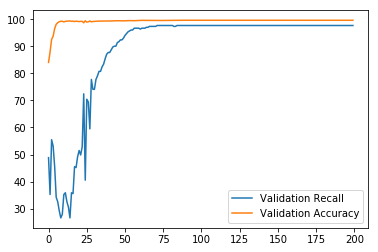

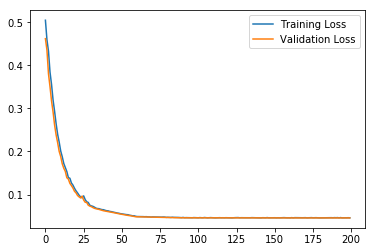

In [28]:
##log log weight 10
plt.plot(val_recall,label='Validation Recall')
plt.plot(val_acc,label='Validation Accuracy')
plt.legend()
plt.show()
plt.plot(train_loss,label='Training Loss')
plt.plot(val_loss,label='Validation Loss')
plt.legend()
plt.show()

In [30]:
model.eval()
with torch.no_grad():
    end = time.time()
    for i, (input, target) in enumerate(validation_generator):
        input = input.unsqueeze(dim = 1).to(device).float()
        target = target.to(device).long()            
        # compute output
        output = model(input)
        loss = criterion(output, target)
        break
outputs = F.softmax(output, dim=1)
predicted = outputs.max(1, keepdim=True)[1]
# total += np.prod(target.shape)
predicted.eq(target.view_as(predicted)).sum()

tensor(65274, device='cuda:0')

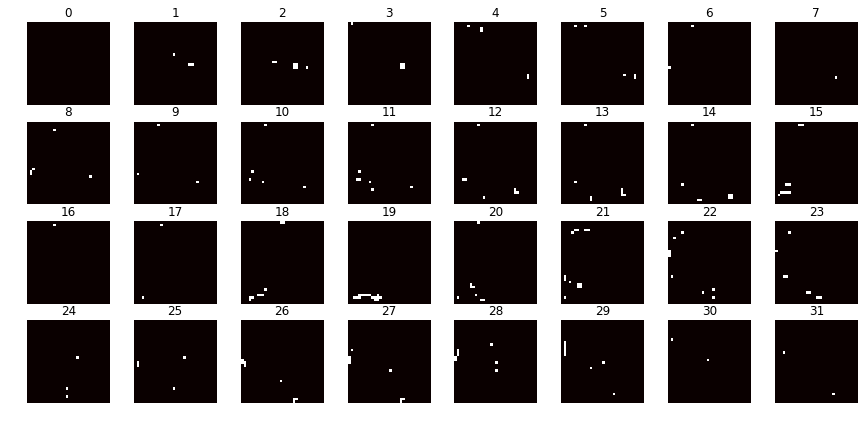

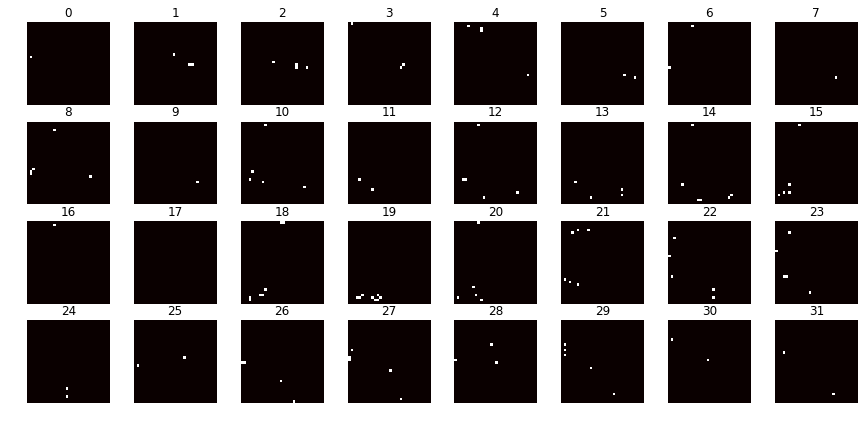

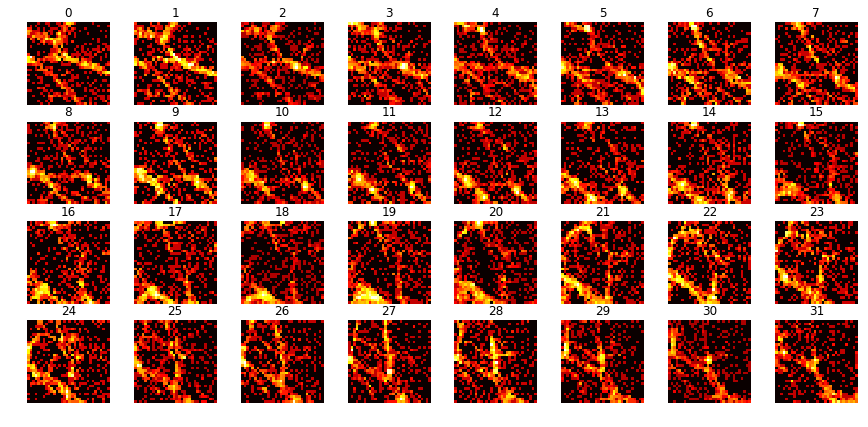

In [31]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4,8,figsize=(15,7))
axs = axs.reshape(-1)
# iterations = [1,2,3,5,10,20,30]
# axs[1].imshow(observation[:1600].reshape(40,40), cmap='Greys')
# axs[1].set_title('after 0 iterations')
# axs[1].set_axis_off()
# axs[0].imshow(np.array(A), cmap='Greys')
# axs[0].set_title('Image')
# axs[0].set_axis_off()
for i in range(32):
    img_arr = predicted[0,0,i,:,:]
    axs[i].imshow(img_arr, cmap='hot')
    axs[i].set_title('%d'%i)
    axs[i].set_axis_off()
# for i in range(32):
    
#     plt.imshow(predicted[0,0,i,:,:])
#     plt.show()

fig, axs = plt.subplots(4,8,figsize=(15,7))
axs = axs.reshape(-1)
# iterations = [1,2,3,5,10,20,30]
# axs[1].imshow(observation[:1600].reshape(40,40), cmap='Greys')
# axs[1].set_title('after 0 iterations')
# axs[1].set_axis_off()
# axs[0].imshow(np.array(A), cmap='Greys')
# axs[0].set_title('Image')
# axs[0].set_axis_off()
for i in range(32):
    img_arr = target[0,i,:,:]
    axs[i].imshow(img_arr, cmap='hot')
    axs[i].set_title('%d'%i)
    axs[i].set_axis_off()
    

fig, axs = plt.subplots(4,8,figsize=(15,7))
axs = axs.reshape(-1)
# iterations = [1,2,3,5,10,20,30]
# axs[1].imshow(observation[:1600].reshape(40,40), cmap='Greys')
# axs[1].set_title('after 0 iterations')
# axs[1].set_axis_off()
# axs[0].imshow(np.array(A), cmap='Greys')
# axs[0].set_title('Image')
# axs[0].set_axis_off()
for i in range(32):
    img_arr = input[0,0,i,:,:]
    axs[i].imshow(img_arr, cmap='hot')
    axs[i].set_title('%d'%i)
    axs[i].set_axis_off()

In [13]:
model

Modified3DUNet(
  (lrelu): LeakyReLU(negative_slope=0.01)
  (dropout3d): Dropout3d(p=0.6)
  (upsacle): Upsample(scale_factor=2, mode=nearest)
  (softmax): Softmax()
  (conv3d_c1_1): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  (conv3d_c1_2): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  (lrelu_conv_c1): Sequential(
    (0): LeakyReLU(negative_slope=0.01)
    (1): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  )
  (inorm3d_c1): InstanceNorm3d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (conv3d_c2): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
  (norm_lrelu_conv_c2): Sequential(
    (0): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=Fa